## Forecasting using time series models

In this notebook we try to predict the weekly sales for the last 8 weeks using time series techniques.

##### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import warnings
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

sns.set_palette("Set2")
%matplotlib inline
warnings.filterwarnings('ignore')

##### Definition of Helper Functions

In [3]:
def error_table(model_name, y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [model_name])

##### Read data

In [4]:
y_train = pd.read_csv("../data/y_train.csv", parse_dates=['Date'], index_col=['Store', 'Date'])
y_test = pd.read_csv("../data/y_test.csv", parse_dates=['Date'], index_col=['Store', 'Date'])
display(y_train)

Sales
Store Date                 
1     2015-06-01  10.122543
      2015-05-25  10.255130
      2015-05-18  10.019536
      2015-05-11   9.972780
      2015-05-04  10.212185
...                     ...
1115  2013-01-28  10.260707
      2013-01-21  10.302532
      2013-01-14  10.036663
      2013-01-07  10.229079
      2012-12-31  10.094562

[136726 rows x 1 columns]

##### Explore time series characteristics at a global level:  

We want to see whether the global sales time series has salient features that allow us to choose a suitable model.

In [5]:
# stack y_train and y_test vertically
y = pd.concat([y_train, y_test], axis=0)
# recover time series at its original scale
y['Sales'] = np.expm1(y['Sales'])
# aggregate the data by date
y_global = y.groupby('Date').sum()
y_global

,Sales
Date,
2012-12-31,36956183.0
2013-01-07,44335162.0
2013-01-14,37252051.0
2013-01-21,43157797.0
2013-01-28,42920978.0
...,...
2015-06-29,51314282.0
2015-07-06,44692076.0
2015-07-13,48506473.0


Let's plot the global time series together with its cummulative average. The shaded region corresponds to the weeks which we have to forecast.

In [6]:
y_global['SalesCumAvg'] = y_global['Sales'].expanding().mean()

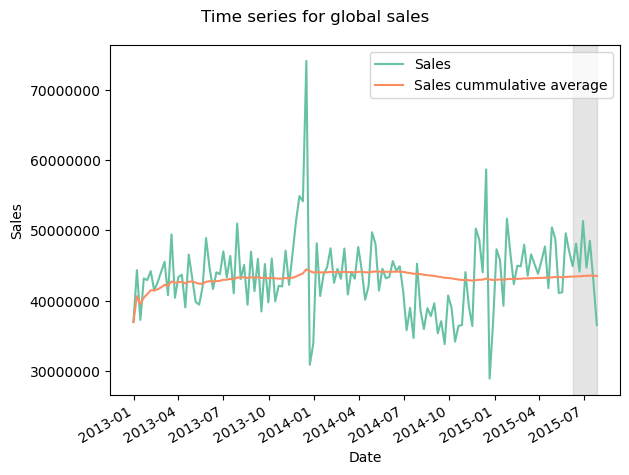

In [7]:
fig, ax = plt.subplots()

ax.plot(y_global.index, y_global['Sales'], label='Sales')
ax.plot(y_global.index, y_global['SalesCumAvg'], label='Sales cummulative average')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.axvspan(datetime(2015,6,8), datetime(2015,7,27), color='#808080', alpha=0.2)
ax.legend(loc='upper right')

fig.autofmt_xdate()
fig.suptitle('Time series for global sales')
# to avoid scientific notation in y ticks
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout();

Now I would like to see how the decomposition of this time series looks like for different periods (in weeks):

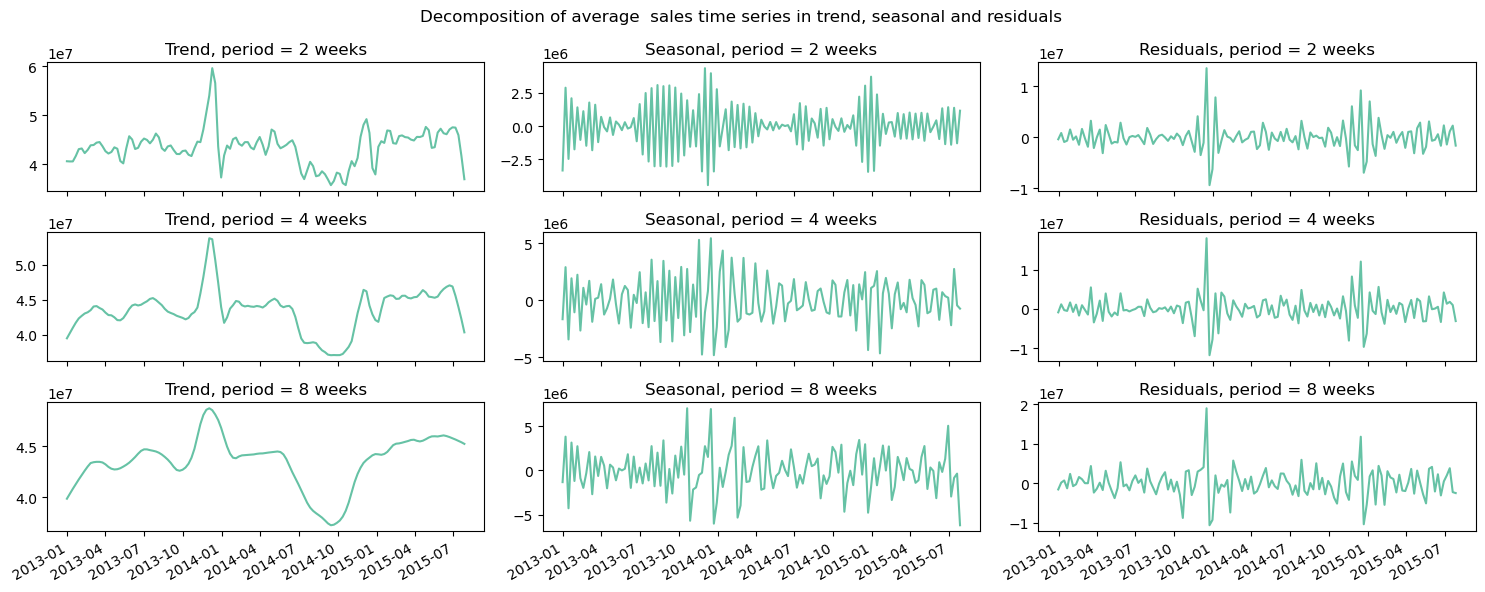

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(15,6))

for i, p in enumerate([2, 4, 8]): 
    decomposition = STL(y_global['Sales'], period=p).fit()
    # Trend
    axs[i, 0].plot(decomposition.trend)
    axs[i, 0].set_title(f'Trend, period = {p} weeks')
    # Seasonal
    axs[i, 1].plot(decomposition.seasonal)
    axs[i, 1].set_title(f'Seasonal, period = {p} weeks')
    # Residuals
    axs[i, 2].plot(decomposition.resid)
    axs[i, 2].set_title(f'Residuals, period = {p} weeks')
    
fig.suptitle('Decomposition of average  sales time series in trend, seasonal and residuals')
fig.autofmt_xdate()
plt.tight_layout();

In [9]:
#Run the augmented Dickey-Fuller test to check if we are dealing with a sationary process:
#ADF_result = adfuller(global_y_train['Sales'])

#print(f'ADF Statistic: {ADF_result[0]}')
#print(f'p-value: {ADF_result[1]}')

#We have a large negative ADF value and a very small p-value, which reinforces the visual intuition that we are dealing with a more or less stationary process.

Let's take a look at the ACF and PACF plots to se if we can recognize some pattern:

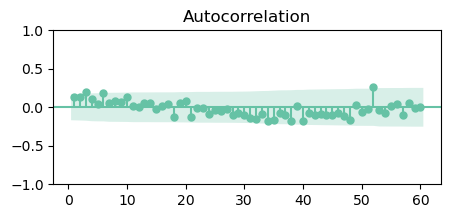

In [10]:
fig, ax = plt.subplots(figsize=(5,2))

plot_acf(y_global['Sales'], zero=False, lags=60, ax=ax);

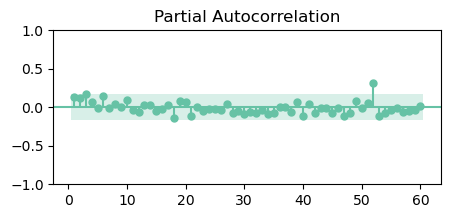

In [11]:
fig, ax = plt.subplots(figsize=(5,2))
plot_pacf(y_global['Sales'], zero=False, lags=60, ax=ax);

I cannot recognize a clear pattern of autoregressive or moving average model. However, I will estimate an autoregression model on the individual stores to see how it performs.

##### Fill missing obervations in train data set with store mean  
As we saw earlier, there are stores which wasn't open for several days. We would like to fill the missing obervations in the train data with the mean in order to be able to perform time series regressions.

In [12]:
# first recover the sales at their original scale
y_train['Sales'] = np.expm1(y_train['Sales'])

In [13]:
# get stores which have mising observations
by_store = y_train.groupby('Store')
obs = by_store.count().rename({'Sales' : 'Observations'}, axis = 1)
max_obs = obs['Observations'].max()

missing_stores = obs[obs['Observations'] < max_obs].index

In [14]:
# fill missing observations with nans
stores = y_train.index.get_level_values(0).unique().sort_values()
dates = y_train.index.get_level_values(1).unique().sort_values()
full_index = pd.MultiIndex.from_product([stores, dates])
y_train = y_train.reindex(full_index)
y_train.isnull().sum()

Sales    4879
dtype: int64

In [15]:
# fill nans (=missing observations) with store means
avgs = y_train.groupby('Store').mean().rename({'Sales' : 'AvgSales'}, axis = 1)
y_train = y_train.join(avgs)
y_train['Sales'] = y_train['Sales'].fillna(y_train['AvgSales'])
y_train.isnull().sum()

Sales       0
AvgSales    0
dtype: int64

In [16]:
# log scale once again
y_train['Sales'] = np.log1p(y_train['Sales'])

##### Autoregressive Model AR(p)

As we saw above, the values for the 3rd, 6th and 52th lags lie outisde the shaded area in the ACF and PACF plots. Therefore we will train an autoregressive model with lags 3, 6 and 52 for each storeasfirst attempt of a time series regression.

In [17]:
# revert to single index on date
y_train_1 = y_train.reset_index(level=[0])
y_test_1 = y_test.reset_index(level=[0])

y_ar_test_list = []
y_ar_pred_list = []

# loop over stores
for s in np.sort(y_train_1['Store'].unique()):
#for s in [1]:
    y_test_s = y_test_1[y_test_1['Store'] == s]['Sales']
    y_train_s = y_train_1[y_train_1['Store'] == s]['Sales']
    # Is good to have also the store as part of the index
    y_test_s.index = pd.MultiIndex.from_tuples([(s, date) for date in y_test_s.index], names=('Store', 'Date'))
    # fit and predict
    ar_model = AutoReg(y_train_s, lags=[3,6,52])
    ar_results = ar_model.fit()
    y_pred_s = ar_results.predict(start=len(y_train_s), end=len(y_train_s) + len(y_test_s) - 1, dynamic=False)
    y_pred_s.index = y_test_s.index
    # append to lists
    y_ar_test_list.append(y_test_s)
    y_ar_pred_list.append(y_pred_s)

# concatenate series
y_ar_test = pd.concat(y_ar_test_list)
y_ar_pred = pd.concat(y_ar_pred_list)

In [18]:
error_table('AR(3,6,52)', np.expm1(y_ar_test), np.expm1(y_ar_pred))

,Model Name,MAE,MAPE,RMSE
"AR(3,6,52)","AR(3,6,52)",4790.535074,0.123433,6266.926267


In [1]:
#Toy example
#y_train_0 = y_train[0]['Sales']
#y_test_0 = y_test[0]['Sales']

#ar_model = AutoReg(y_train_0, lags=[3,6])
#ar_results = ar_model.fit()
#y_pred_0 = ar_results.predict(start=len(y_train_0), end=len(y_train_0) + len(y_test_0) - 1, dynamic=False)

#error_table( 'AR(1)', np.expm1(y_test_0), np.expm1(y_pred_0))